In [11]:
%matplotlib inline
import numpy as np
from kf_book.book_plots import figsize, set_figsize
import kf_book.book_plots as book_plots
import matplotlib.pyplot as plt
from filterpy.discrete_bayes import update, predict, normalize


这一章主要基于贝叶斯条件概率理论和全概率理论建立的Discrete_Bayes Filter。

Bayes theorem is

$$P(x_{i+1} \mid Z) = \frac{P(Z \mid x_i) P(x_i)}{P(Z)}$$


我们可以发现，**贝叶斯理论**正好表达的是这样的一个过程：

$$ \mathtt{posterior} = normalization( \mathtt{likelihood}\times \mathtt{prior} )$$ 

这正好是后验假设度过程，即：

>*在测量值为`Z`的情况下，下一个状态值为$x_{i+1}$*的**可能性** = 当前状态$x_i$的**可能性** X *在当前状态情况下,下一状态为$x_{i+1}$*的**可能性**

Total Probability Theorem is

$$P(x_i^{t+1}) = \sum_j P(x_i^{t+1} | x_j^{t})  P(x_j^{t})$$

**全概率理论**又正好表达的是先验假设的过程，即：

>*在`t+1`时刻，`i`位置的状态存在*的**可能性描述**$x_i^{t+1}$ **$=$** *在`t`时刻，与`i`位置相关的`j`位置的状态存在*的**可能性描述**$x_i^{t}$ **$\times$** *在`t`时刻`j`位置状态存在情况下，接下来`i`位置的状态也存在*的**可能性**

<font face='楷体', size=5>
因此，Discrete_Bayes Filter可以用来估计这样一类问题，即：
</font>

><font face='楷体', size=5>
一个物体在一个确定的轨道上，从未知的某个地方开始，以差不多稳定的速度单项运动，其中差不多稳定的速度也可能造成短时低概率的逆向行驶。</font>


其中重要的三个函数分别为：
``` python
from filterpy.discrete_bayes import update, predict

likelihood = lh_hallway(hallway, z, z_prob);  #$P(Z \mid x_i)$
prior = predict(posterior, move, *kernel); # $P(x_i)$
posterior = undate(likelihood,prior);  #$P(x_i \mid Z)$
```

> 其中，`hallway`是由离散点描述的确定的轨道，`z`是相应轨道描述，每次采样得到当前位置状态的测量值，`z_prob`是测量状态的可信度，`move`是移动速度假设，`*kernel`正是在`t`时刻每个`j`位置状态存在情况下，接下来`i`位置的状态也存在的可能性预判

接下来看各例子：


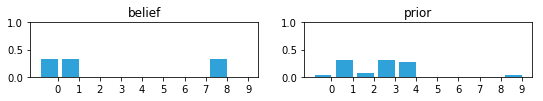

In [31]:
def predict_move(belief,move, *kernel):
    n=len(belief)
    prior = np.zeros(n)
    p_correct, p_over, p_under = kernel
    for i in range(n):
        prior[i] = (
            belief[(i-move) % n] * p_correct +
            belief[(i-move-1) % n] * p_over +
            belief[(i-move+1) % n] * p_under)
    return prior

belief = normalize([1,1,0,0,0,0,0,0,1,0])
#belief = normalize(np.abs(np.random.randn(10)))

prior = predict_move(belief, 2, .1, .8, .1)
book_plots.plot_belief_vs_prior(belief,prior)
set_figsize(y=1)


这个例子仅仅描述了，对应`t`时刻，每个`i`位置状态存在的可能性，在经过一次运动后，受kernel的影响，`t+1`时刻，每个`i`位置状态存在的可能性。kernel描述的含义是：`t+1`时刻，运动到下一个位置处的状态存在的可能性，受到它及它的前后三个位置处原本状态存在的可能性的影响，影响因子为0.1, 0.8, 0.1。

接下来，再看一下连续测量后，估计当前可能位置的例子;


[1 0 1 0 0 1 0 1 0 0]


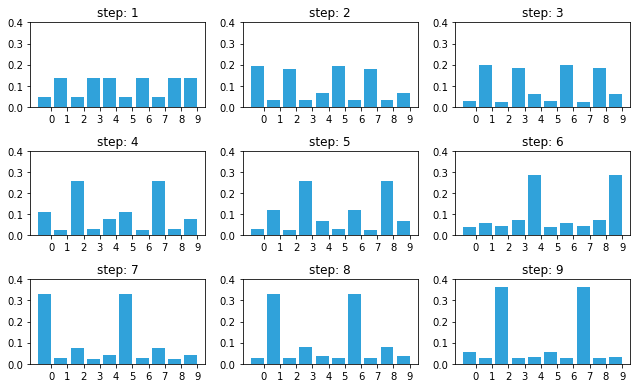

In [32]:
def lh_hallway(hall,z,z_prob):
    """ compute likelihood that a measurement matches
    positions in the hallway."""
    try:
        scale = z_prob / (1. - z_prob)
    except ZeroDivisionError:
        scale = 1e8
        
    likelihood = np.ones(len(hall))
    likelihood[hall == z] *= scale
    return likelihood


with figsize(y=5.5):
    hallway = np.asarray([1, 0, 1, 0, 0]*2)   #表达的是一个由五个离散点来描述的循环轨道。
    prior = np.asarray([.1]*10)
    offset = 1
    kernel = np.asarray([.1, .8, .1])
    measurement = [0, 1, 0, 1, 0, 0, 1, 0, 1]  #表达的是连续九次测量，每次测量到当前所处位置的状态。
    for i, m in enumerate(measurement):
        likelihood = lh_hallway(hallway, z=m, z_prob=0.75)
        posterior = update(likelihood,prior)
        prior = predict(posterior, offset, kernel)
        plt.subplot(3,3,i+1)
        book_plots.bar_plot(posterior,ylim=(0,.4),title='step: {}'.format(i+1))
    plt.tight_layout() #区别在于，可以让个子图彼此分离，不至于title和图片重叠
print(hallway)


为了更好验证题设，我们倒着来看。  
measurement = [0, 1, 0, 1, 0, 0, 1, 0, 1]  
hallway = [1 0 1 0 0 1 0 1 0 0]  
首先，这两个list分别描述测量值和轨道描述。我们倒着来看measurement和图，我们可以发现：
测量值为1，出现的最大概率在2位置和7位置，由于我们知道轨道是五个离散点描述的循环轨道，所以，2位置和7位置是一个位置。2位置符合hallway应有的状态
随后，测量值为0，出现的最大概率在1位置，而1位置符合hallway应有的状态。
依次向前，我们可以发现，每次概率较大的位置，都是测量值次序最符合hallway次序的当前状态位置，并且，随着测量的增多，无论测量是否存在错误，结果都会更加逼近准确估计。

这个估计方法，我们通常可以用在流水线上，我们可能不知道他从哪里开始的，但是多次测量后，便可以知晓。


In [33]:
from IPython.display import HTML

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/9by46AAqz70" frameborder="0" allowfullscreen></iframe>')
